In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn as sk
from ase.io import read, write

from pymatgen.io.cif import CifParser
import pickle
plt.rcParams['font.size'] = '15'

2023-07-09 14:54:07.491119: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 14:54:07.578792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 14:54:07.580057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 14:54:08.962697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# define some parameters
# Constant
# k2kjmol = 0.00831446 # constants. Convert K to kJ/mol
#ev2kjmol = 96.487 # constants. Convert eV to kJ/mol

# number of movie frames
nframe = 3000 

# MOF information
mof_file = "CONTCAR.cif"
sc_fac=  [4,2,2] # multiply by this vector to get a supercell

In [3]:
# read DFT extxyz file
extxyz = "co2_mof74_3000.xyz"
system = read(extxyz, format='extxyz', index=':')

In [4]:
# read energy values
energy = np.array([])  # in eV

# read energy into energy list
for i, frame in enumerate(system):
    energy = np.append(energy, frame.get_potential_energy())


In [5]:
# Initialize a CifParser object
parser = CifParser(mof_file)

# Parse the CIF file and obtain a Structure object
structure = parser.get_structures(primitive=False)[0]

supercell = structure * sc_fac

In [6]:
# Read CO2 position into a list
co2_frac_coords = []

    
# read each frame of xyz file
for i, frame in enumerate(system):

        # expand the first 54 atoms in system to a supercell
        frame = frame * sc_fac

        # get fractional coordiantes
        frac_coord = frame.get_scaled_positions()
        co2_frac_coords.append(frac_coord[54:57])



In [75]:
# # write supercell and co2_frac_coords to a xyz file
# f = open('test.xyz', 'w')

# for site in supercell:
#     f.write(site.species_string + ' ' + str(site.frac_coords[0]) + ' ' + str(site.frac_coords[1]) + ' ' + str(site.frac_coords[2]) + '\n')

# f.write('C' + ' ' + str(co2_frac_coords[0][0][0]) + ' ' + str(co2_frac_coords[0][0][1]) + ' ' + str(co2_frac_coords[0][0][2]) + '\n')
# f.write('O' + ' ' + str(co2_frac_coords[0][1][0]) + ' ' + str(co2_frac_coords[0][1][1]) + ' ' + str(co2_frac_coords[0][1][2]) + '\n')
# f.write('O' + ' ' + str(co2_frac_coords[0][2][0]) + ' ' + str(co2_frac_coords[0][2][1]) + ' ' + str(co2_frac_coords[0][2][2]) + '\n')

# f.close()


In [7]:
co2_frac_coords[0]

array([[0.21588591, 0.13302503, 0.20339396],
       [0.24129302, 0.14464716, 0.18143383],
       [0.19051517, 0.1214029 , 0.22535408]])

In [8]:
# define a distance function
def pairdist(host_site, ads_frac,supercell):

    da = host_site.frac_coords[0] - ads_frac[0]
    db = host_site.frac_coords[1] - ads_frac[1]
    dc = host_site.frac_coords[2] - ads_frac[2]
    
    # minimum image convension
    da -= round(da)
    db -= round(db)
    dc -= round(dc)

    # distance
    cart_coords = supercell.lattice.get_cartesian_coords(np.array([da,db,dc]))
    dist2 = cart_coords[0]**2 + cart_coords[1]**2 + cart_coords[2]**2
    dist = np.sqrt(dist2)
    
    return dist

# define a unique feature function
def dist_feature(r):
    return np.array([np.exp(-r),r**(-1),r**(-4),r**(-6),r**(-8),r**(-10)])

In [9]:
# initialize feature
feature = np.array([])

# loop over each frame
for i in range(nframe):
    
    cmg = np.array([])
    co = np.array([])
    cc = np.array([])
    ch = np.array([])
    omg = np.array([])
    oo = np.array([])
    oc = np.array([])
    oh = np.array([])


    for j in range(3):

        # 'C'
        if j == 0:
            
            # read in coordinates of atoms in an adsorbate molecule
            ads_frac = np.array([co2_frac_coords[i][j][0],co2_frac_coords[i][j][1], co2_frac_coords[i][j][2]])
        

            # loop over all framework atoms:
            for site in supercell:

                # calculate pair distance
                dist = pairdist(site, ads_frac,supercell)
            
                if site.species_string == 'Mg':
                    cmg = np.append(cmg,dist)
                elif site.species_string == 'O':
                    co = np.append(co,dist)
                elif site.species_string == 'C':
                    cc = np.append(cc,dist)
                elif site.species_string == 'H':
                    ch = np.append(ch,dist)

        # 'O
        else:
            # read in coordinates of atoms in an adsorbate molecule
            ads_frac = np.array([co2_frac_coords[i][j][0],co2_frac_coords[i][j][1], co2_frac_coords[i][j][2]])
    
            
            # loop over all framework atoms:
            for site in supercell:

                # calculate pair distance
                dist = pairdist(site, ads_frac,supercell)
            
                if site.species_string == 'Mg':
                    omg = np.append(omg,dist)
                elif site.species_string == 'O':
                    oo = np.append(oo,dist)
                elif site.species_string == 'C':
                    oc = np.append(oc,dist)
                elif site.species_string == 'H':
                    oh = np.append(oh,dist)
           
                
    # sort array in ascending order
    cmg = np.sort(cmg)
    co = np.sort(co)
    cc = np.sort(cc)
    ch = np.sort(ch)  
    omg = np.sort(omg)
    oo = np.sort(oo)
    oc = np.sort(oc)
    oh = np.sort(oh)


    # pick the first 9 elements in array and add them to feature array
    for k in range(9):
        feature = np.append(feature, dist_feature(cmg[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(co[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(cc[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(ch[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(omg[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(oo[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(oc[k]))
    for k in range(9):
        feature = np.append(feature, dist_feature(oh[k]))


    print('finished frame: {}'.format(i+1))

finished frame: 1
finished frame: 2
finished frame: 3
finished frame: 4
finished frame: 5
finished frame: 6
finished frame: 7
finished frame: 8
finished frame: 9
finished frame: 10
finished frame: 11
finished frame: 12
finished frame: 13
finished frame: 14
finished frame: 15
finished frame: 16
finished frame: 17
finished frame: 18
finished frame: 19
finished frame: 20
finished frame: 21
finished frame: 22
finished frame: 23
finished frame: 24
finished frame: 25
finished frame: 26
finished frame: 27
finished frame: 28
finished frame: 29
finished frame: 30
finished frame: 31
finished frame: 32
finished frame: 33
finished frame: 34
finished frame: 35
finished frame: 36
finished frame: 37
finished frame: 38
finished frame: 39
finished frame: 40
finished frame: 41
finished frame: 42
finished frame: 43
finished frame: 44
finished frame: 45
finished frame: 46
finished frame: 47
finished frame: 48
finished frame: 49
finished frame: 50
finished frame: 51
finished frame: 52
finished frame: 53
fi

In [10]:
# reshape
feature = feature.reshape(-1, 432)
energy = energy.reshape(-1, 1)

print(feature.shape)
print(energy.shape)

# save feature and energy to a pickle file
with open('feature_energy.pickle', 'wb') as f:
    pickle.dump([feature, energy], f)

(3000, 432)
(3000, 1)


In [11]:
# load in "feature_energy.pickle" file and it contains a list of two arrays
with open('feature_energy.pickle', 'rb') as f:
    feature, energy = pickle.load(f)

feature.shape

(3000, 432)

In [12]:
# convert energy from eV to kJ/mol for Lin's model testing in gRASPA
#energy = energy * ev2kjmol

In [13]:
energy

array([[ 0.49507169],
       [ 0.47125894],
       [-0.12669157],
       ...,
       [-0.13236036],
       [-0.13202653],
       [-0.25893805]])

In [14]:
# split feature into training and testing set
# I want 1000 data points to be in the testing set
X_train, X_test, y_train, y_test = train_test_split(feature, energy, test_size=800, random_state=42)

# use min-max to normalize feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
mini = scaler.data_min_
maxi = scaler.data_max_

# write mini and maxi array to the same file
with open('minimax.txt', 'w') as f:
    for i in range(len(mini)):
        f.write('{} {}\n'.format(mini[i], maxi[i]))


In [16]:
tf.keras.backend.set_floatx('float32')

In [17]:
# A deep neural network with 5 hidden layers with 50 neurons each, use ReLU as activation function and learning rate of 0.001, 1000 epochs
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    # output layer with one neuron
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Train the model with early stopping
# this early stop criteria is to stop training when the validation loss does not decrease for xx consecutive epochs (adopted by Max Welling et al.)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
# reduce learning rate when validation loss does not decrease for 10 consecutive epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-6)
# train the model with validation set from training set=20%
history = model.fit(X_train, y_train, epochs=100000, batch_size = 16, validation_split=0.091, verbose=1, callbacks=[early_stop, reduce_lr])

Epoch 1/100000
125/125 [==============================] - 2s 4ms/step - loss: 0.0721 - mean_absolute_error: 0.1232 - val_loss: 0.0183 - val_mean_absolute_error: 0.0681 - lr: 0.0010
Epoch 2/100000
125/125 [==============================] - 0s 2ms/step - loss: 0.0241 - mean_absolute_error: 0.0765 - val_loss: 0.0131 - val_mean_absolute_error: 0.0692 - lr: 0.0010
Epoch 3/100000
125/125 [==============================] - 0s 2ms/step - loss: 0.0178 - mean_absolute_error: 0.0707 - val_loss: 0.0083 - val_mean_absolute_error: 0.0470 - lr: 0.0010
Epoch 4/100000
125/125 [==============================] - 0s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0494 - val_loss: 0.0145 - val_mean_absolute_error: 0.0622 - lr: 0.0010
Epoch 5/100000
125/125 [==============================] - 0s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0494 - val_loss: 0.0067 - val_mean_absolute_error: 0.0407 - lr: 0.0010
Epoch 6/100000
125/125 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_abs

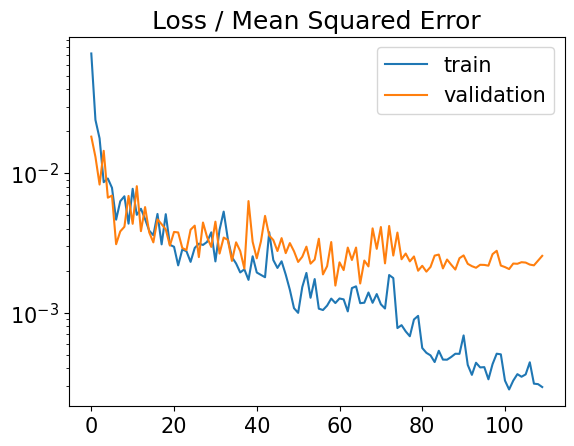

In [18]:
# plot the loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.yscale('log')

 1/25 [>.............................] - ETA: 0s

25/25 [==============================] - 0s 2ms/step


Text(0.05, 0.9, 'MAE = 17.818 meV')

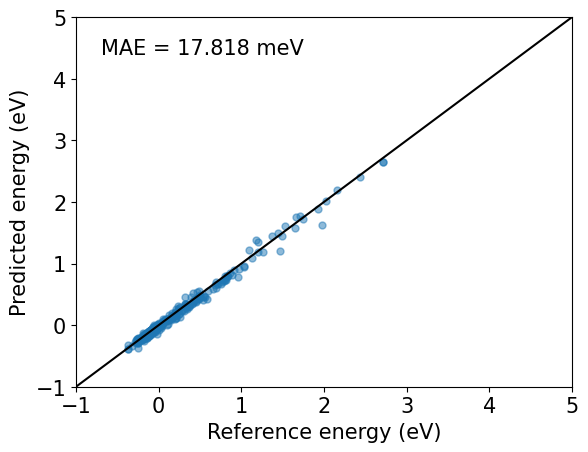

In [21]:
# Evaluate the model using mean absolute error
#model.evaluate(X_test, y_test)

# predict value based on a test set
y_pred = model.predict(X_test)

# in eV
plt.plot(y_test, y_pred, 'o', markersize=5, alpha=0.5)
plt.plot([-2, 10], [-2, 10], '-', color='black')
plt.xlabel('Reference energy (eV)')
plt.ylabel('Predicted energy (eV)')
plt.xlim([-1, 5])
plt.ylim([-1, 5])
# mark the MAE
plt.text(0.05, 0.9, 'MAE = %.3f meV' % np.mean(np.abs(np.array(y_test) - np.array(y_pred))*1000), transform=plt.gca().transAxes)

# in kJ/mol
# plt.plot(y_test, y_pred, 'o', markersize=5, alpha=0.5)
# plt.plot([-200, 1000], [-200, 1000], '-', color='black')
# plt.xlabel('Reference energy (kJ/mol)')
# plt.ylabel('Predicted energy (kJ/mol)')
# plt.xlim([-100, 500])
# plt.ylim([-100, 500])
# # mark the MAE
# plt.text(0.05, 0.9, 'MAE = %.3f kJ/mol' % np.mean(np.abs(np.array(y_test) - np.array(y_pred))), transform=plt.gca().transAxes)


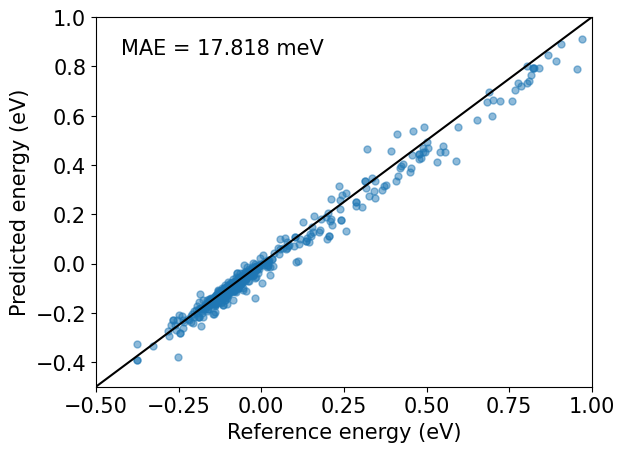

In [23]:
# make a parity plot in eV
plt.plot(y_test, y_pred, 'o', markersize=5, alpha=0.5)
plt.plot([-2, 10], [-2, 10], '-', color='black')
plt.xlabel('Reference energy (eV)')
plt.ylabel('Predicted energy (eV)')
plt.xlim([-0.5, 1])
plt.ylim([-0.5, 1])
# mark the MAE
plt.text(0.05, 0.9, 'MAE = %.3f meV' % np.mean(np.abs(np.array(y_test) - np.array(y_pred))*1000), transform=plt.gca().transAxes)


# in kJ/mol
# plt.plot(y_test, y_pred, 'o', markersize=5, alpha=0.5)
# plt.plot([-200, 1000], [-200, 1000], '-', color='black')
# plt.xlabel('Reference energy (kJ/mol)')
# plt.ylabel('Predicted energy (kJ/mol)')
# plt.xlim([-50, 100])
# plt.ylim([-50, 100])
# # mark the MAE
# plt.text(0.05, 0.9, 'MAE = %.3f kJ/mol' % np.mean(np.abs(np.array(y_test) - np.array(y_pred))), transform=plt.gca().transAxes)

# write the plot to file 
plt.savefig('parity_plot.png', dpi=300, bbox_inches='tight')


In [22]:
# # predict value based on a test set
# y_pred_train = model.predict(X_train)

# plt.title('Training set')
# plt.plot(y_train, y_pred_train, 'o', markersize=5, alpha=0.5)
# plt.plot([-2, 10], [-2, 10], '-', color='black')
# plt.xlabel('Reference energy (eV)')
# plt.ylabel('Predicted energy (eV)')
# plt.xlim([-1, 5])
# plt.ylim([-1, 5])
# # mark the MAE
# plt.text(0.05, 0.9, 'MAE = %.3f meV' % np.mean(np.abs(np.array(y_train) - np.array(y_pred_train))*1000), transform=plt.gca().transAxes)

In [24]:
# save the model using SavedModel format
model.save('DP_model_CO2_MgMOF74_LinModel_float32')


INFO:tensorflow:Assets written to: DP_model_CO2_MgMOF74_LinModel_float32/assets


INFO:tensorflow:Assets written to: DP_model_CO2_MgMOF74_LinModel_float32/assets
